# Visualizing the saliency maps

Once your classifier is trained you can visualize which pixels where the most relevant to classify an image as a certain label. This is what we call the *saliency maps*.

We will use the implementations of different saliency functions from the [deep-viz repository](https://github.com/experiencor/deep-viz-keras) by [experiencor](https://github.com/experiencor) which allows the visualization of saliency maps for keras models.

**Remarks:** For some reason the code seems to fail when using the `Xception` architecture. `ResNet` for example, works fine though.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2021-10-26_Lab_All_Copas_All_reg'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

W1029 10:12:46.074883 140001386551104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1029 10:12:46.077307 140001386551104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1029 10:12:46.079180 140001386551104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Now you can select a file in your computer in which to visualize the saliency maps. 
Possible visualizations include:
* [Vanila gradient](https://arxiv.org/abs/1312.6034)
* [Guided backprop](https://arxiv.org/abs/1412.6806)
* [Integrated gradients](https://arxiv.org/abs/1703.01365)
* [Visual backprop](https://arxiv.org/abs/1611.05418)

Each of them is accompanied with the corresponding [smoothgrad](https://arxiv.org/abs/1706.03825) version, which improves on any baseline method by adding random noise.

In [2]:
cd ..

/srv/image-classification-tf


[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 3s 3s/step
Predicted value:
98.29881286621094


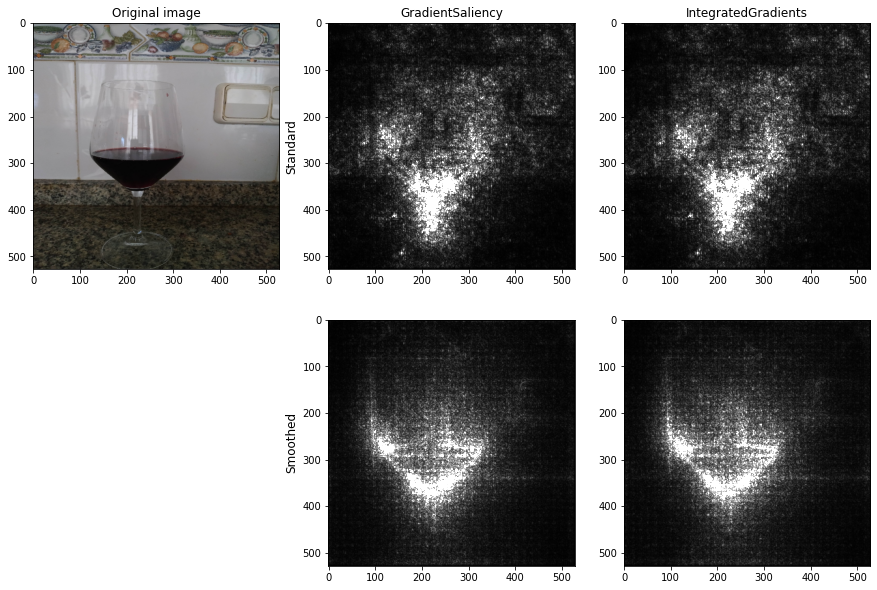

In [4]:
FILEPATH = '/srv/datos/Voluntarios/5c61f838-32bc-4faa-858d-a215981d0618_otra_crianza_125_copa_cata_almuerzo_14-06-2021_13-22-58.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
229.23744201660156


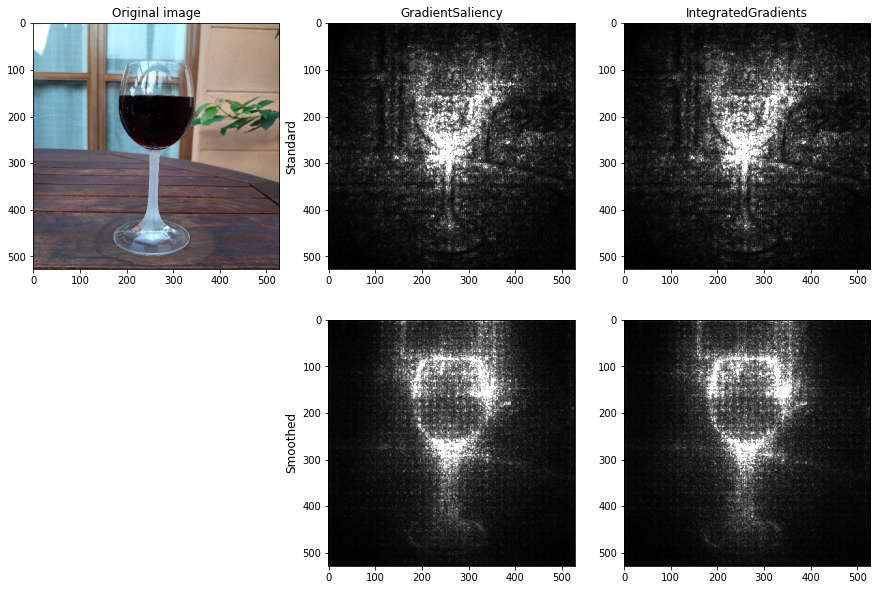

In [5]:
FILEPATH = '/srv/datos/Voluntarios/9a4bbc89-d0e6-4a7c-98af-2e588d9ae21b_otra_crianza_100_copa_chard_fuera_29-05-2021_18-30-51.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
159.9296875


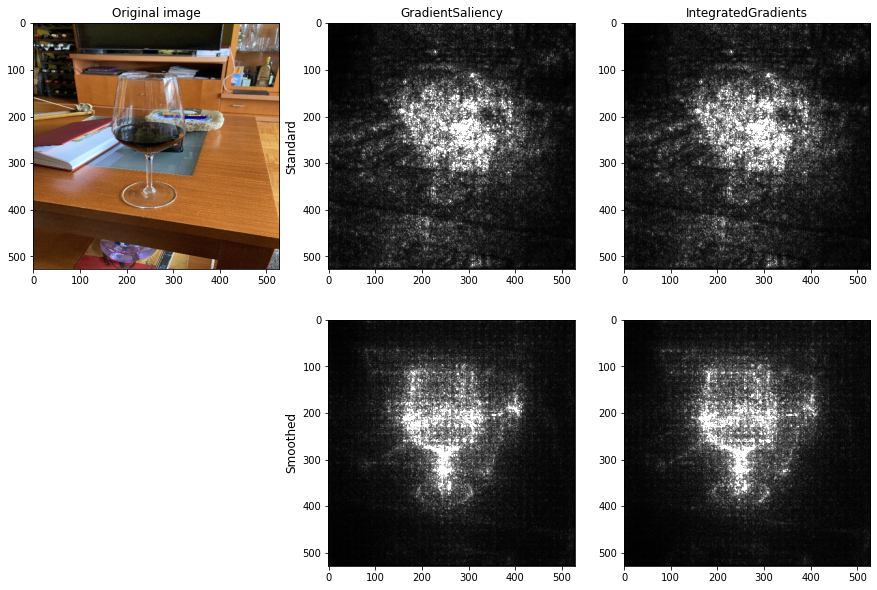

In [6]:
FILEPATH = '/srv/datos/Voluntarios/7f197478-71bd-4720-a295-65d443ff12bf_otra_crianza_125_copa_cata_almuerzo_11-06-2021_12-03-55.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
97.52021789550781


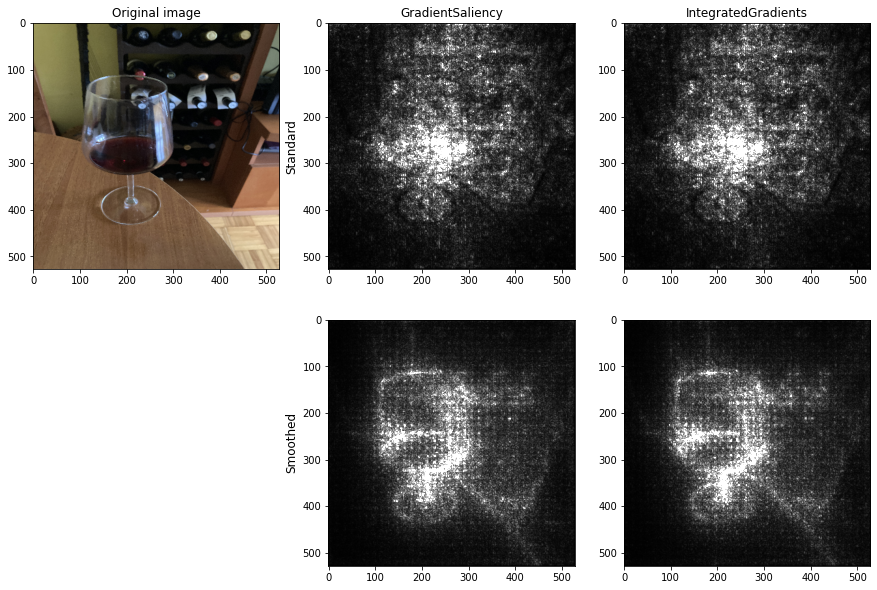

In [7]:
FILEPATH = '/srv/datos/Voluntarios/7f197478-71bd-4720-a295-65d443ff12bf_otra_crianza_125_copa_cata_almuerzo_18-06-2021_12-05-48.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 1s 972ms/step
Predicted value:
75.4007797241211


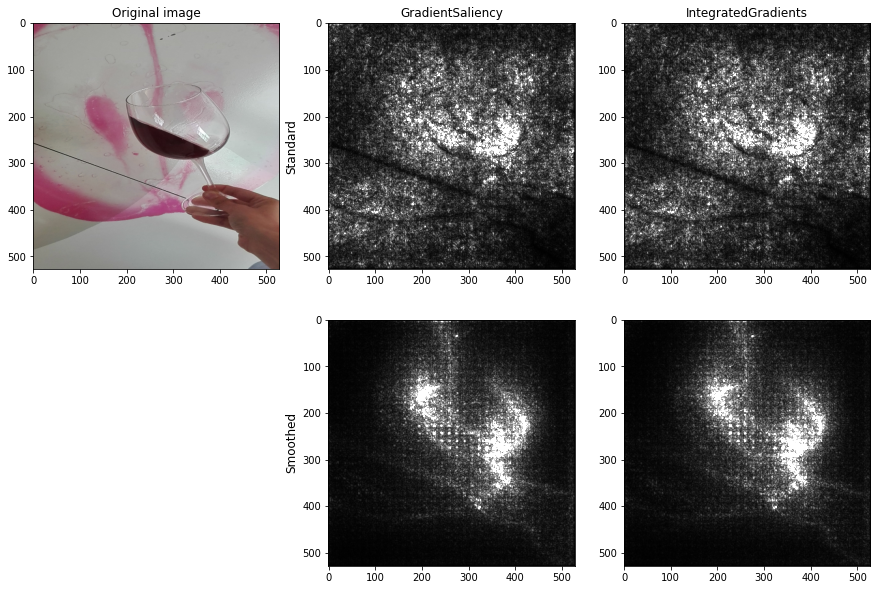

In [14]:
FILEPATH = '/srv/datos/Voluntarios/2430bc93-a971-489d-b02f-ecaf4b3c16ce_rioja_reserva_100_copa_burd_nd_interior_sin_flash_nd_cercano_inferior_sin_18-05-2021_14-07-57.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
87.80070495605469


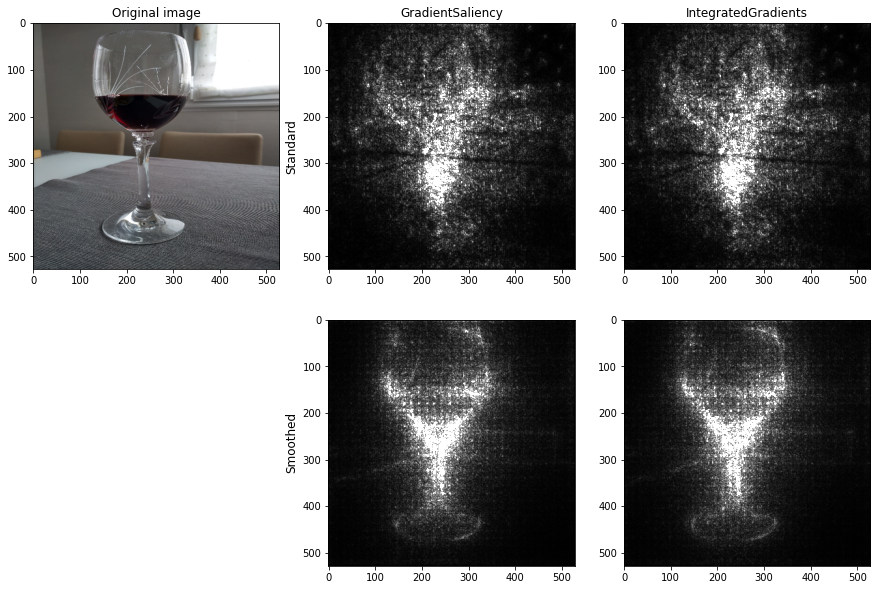

In [9]:
FILEPATH = '/srv/datos/Voluntarios/8ec17b0f-b668-49d7-8d6e-9799c5601a30_otra_crianza_50_copa_borg_almuerzo_02-06-2021_13-32-47.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 1s 696ms/step
Predicted value:
140.4343719482422


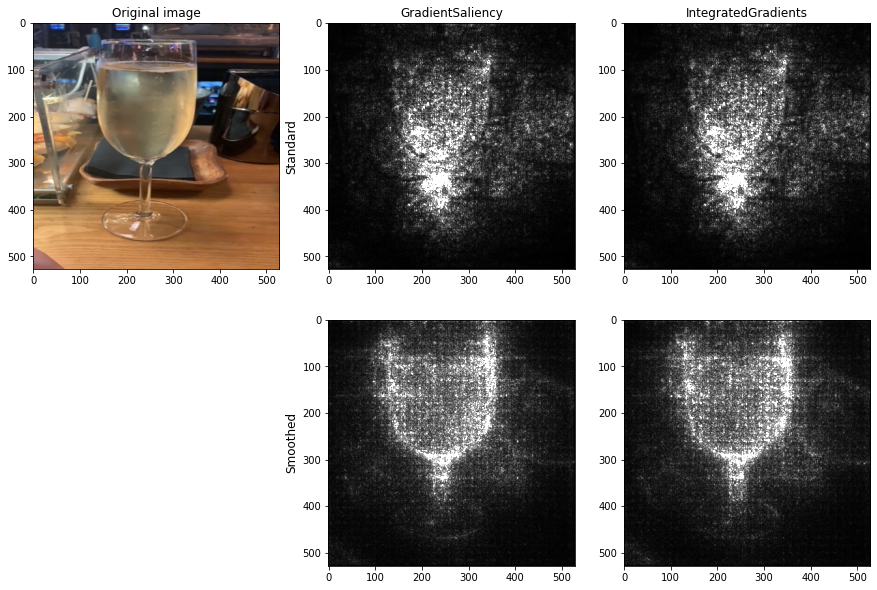

In [15]:
FILEPATH = '/srv/datos/Voluntarios/77a8efd5-2a40-411e-9e58-c403a27e15c8_otra_joven_75_copa_chard_fuera_03-06-2021_10-48-46.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
73.06485748291016


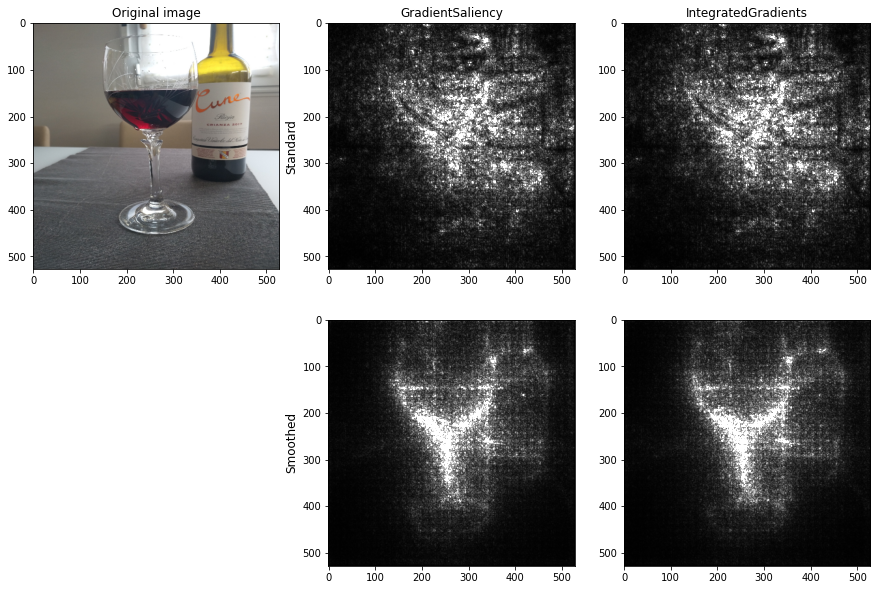

In [11]:
FILEPATH = '/srv/datos/Voluntarios/8ec17b0f-b668-49d7-8d6e-9799c5601a30_otra_crianza_100_copa_borg_almuerzo_01-06-2021_13-45-56.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 1s 903ms/step
Predicted value:
63.23685836791992


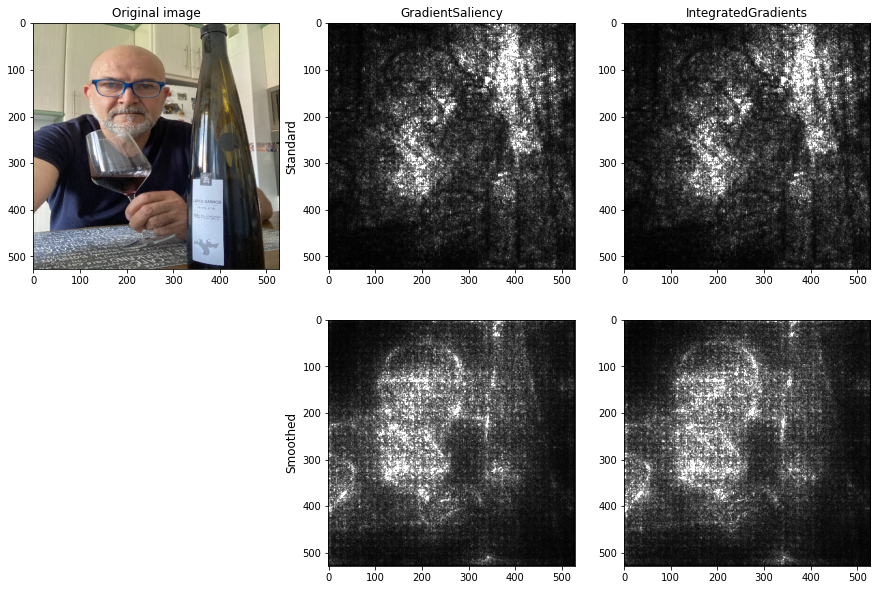

In [12]:
FILEPATH = '/srv/datos/Voluntarios/7f197478-71bd-4720-a295-65d443ff12bf_otra_crianza_125_copa_cata_almuerzo_27-05-2021_20-13-33.jpeg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 1s 1s/step
Predicted value:
81.97673797607422


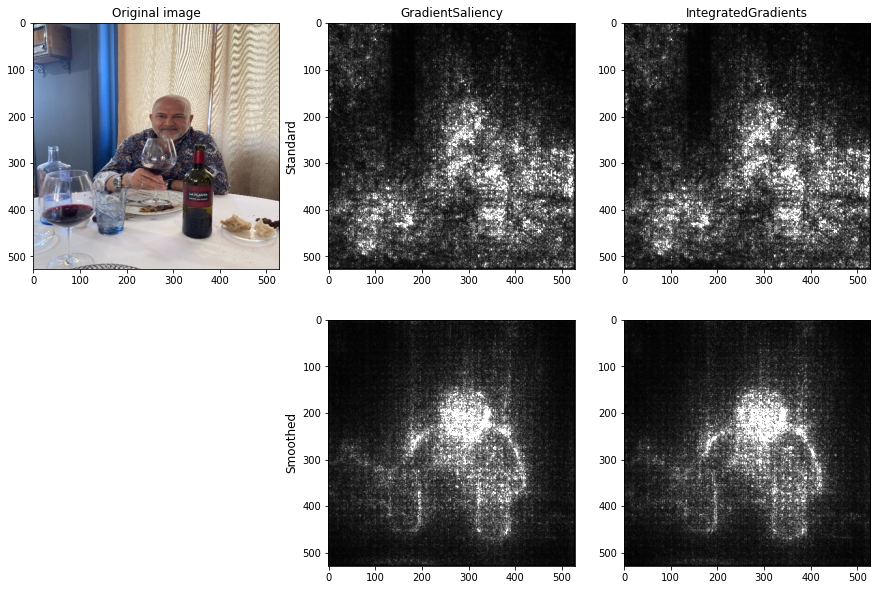

In [13]:
FILEPATH = '/srv/datos/Voluntarios/7f197478-71bd-4720-a295-65d443ff12bf_otra_crianza_150_copa_borg_almuerzo_25-05-2021_19-55-55.jpeg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 3s 3s/step
Predicted value:
190.40428161621094


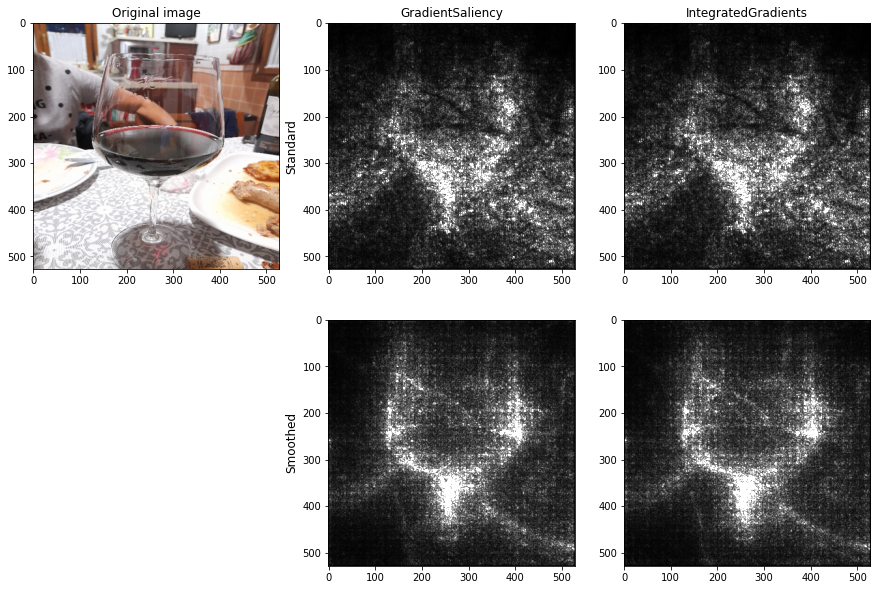

In [3]:
FILEPATH = '/srv/datos/Voluntarios/cfc2a9a8-cf03-461b-8e50-63d3b28c6366_otra_reserva_150_copa_borg_cena_28-05-2021_20-27-42.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0])) # en esta el brazo podria estar confundiendo a la red